# Deep Learning Framework: PyTorch
Author: James Chen, School of Animal Sciences, Virginia Tech

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as torch_datasets
import torchvision.transforms as transforms
from torchinfo import summary
from poutyne import Model, Experiment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Dataset

### Download datasets CIFAR10

In [3]:
# load data
# https://pytorch.org/vision/stable/datasets.html
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4
trainset = torch_datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testset = torch_datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


### Validate images

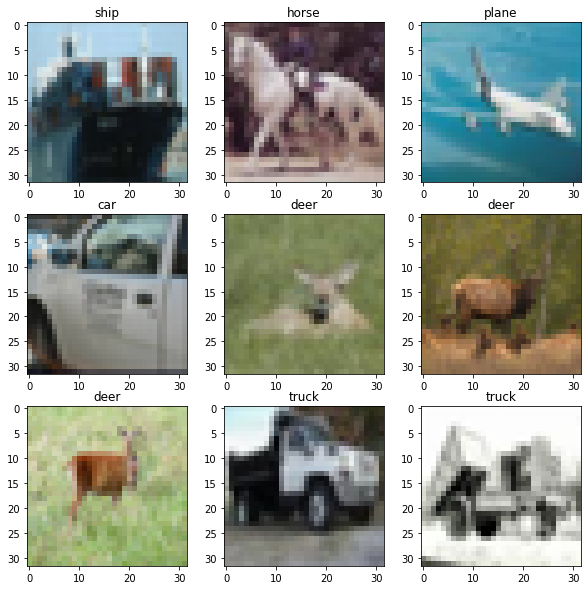

In [4]:
# validate image
def get_item(datasets, idx, transform=True):
    img, lb = datasets.__getitem__(idx)
    if transform:
        return ((img / 2 + 0.5).numpy().transpose((1, 2, 0)), lb)
    else:
        return (img, lb)

n = len(trainset.data)
nimg = 9
fig = plt.figure(figsize=(10, 10))
for i in range(nimg):
    idx = np.random.randint(n)
    img, lb = get_item(trainset, idx)
    axs = fig.add_subplot(3, 3, i + 1)
    axs.imshow(img)
    axs.set_title(classes[lb])

### Define neural network

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
net = Net()
# GPU
device = torch.device("mps")
net.to(device)
# summary
summary(net, (30, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [30, 10]                  --
├─Conv2d: 1-1                            [30, 6, 28, 28]           456
├─MaxPool2d: 1-2                         [30, 6, 14, 14]           --
├─Conv2d: 1-3                            [30, 16, 10, 10]          2,416
├─MaxPool2d: 1-4                         [30, 16, 5, 5]            --
├─Linear: 1-5                            [30, 120]                 48,120
├─Linear: 1-6                            [30, 84]                  10,164
├─Linear: 1-7                            [30, 10]                  850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Total mult-adds (M): 19.75
Input size (MB): 0.37
Forward/backward pass size (MB): 1.56
Params size (MB): 0.25
Estimated Total Size (MB): 2.18

### Loss function

In [7]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Callback

In [8]:
import os
from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Callback, ModelBundle, SKLearnMetrics, plot_history

save_path = "save_model/model"
os.makedirs(save_path, exist_ok=True)
callbacks = [
    # Save the latest weights to be able to continue the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_epoch.ckpt')),

    # # Save the weights in a new file when the current model is better than all previous models.
    # ModelCheckpoint(os.path.join(save_path, 'best_epoch_{epoch}.ckpt'), monitor='val_acc', mode='max',
    #                 save_best_only=True, restore_best=True, verbose=True),

    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

### Train the model

In [30]:
# training
# https://github.com/GRAAL-Research/poutyne
# model = Model(net, optimizer, loss_function)
# model.fit_generator(trainloader, testloader, epochs=2)
model = Model(net, optimizer, loss_function)
model.load_weights("save_model/best_epoch_6.ckpt")

<All keys matched successfully>

### Validate results

    epoch       time     lr      loss  cross_entropy  val_loss  \
0       1  89.343466  0.001  1.715208       1.715208  1.416166   
1       2  89.061666  0.001  1.341373       1.341373  1.254298   
2       3  89.299752  0.001  1.198865       1.198865  1.183276   
3       4  89.982761  0.001  1.100783       1.100783  1.140636   
4       5  88.957415  0.001  1.030473       1.030473  1.170482   
5       6  88.506846  0.001  0.971584       0.971584  1.088866   
6       7  88.526594  0.001  0.927577       0.927577  1.092386   
7       8  88.510026  0.001  0.883297       0.883297  1.091709   
8       9  88.812390  0.001  0.850594       0.850594  1.123881   
9      10  88.530900  0.001  0.817725       0.817725  1.142027   
10     11  88.278647  0.001  0.799252       0.799252  1.174974   
11     12  88.375024  0.001  0.770119       0.770119  1.150890   
12     13  88.539615  0.001  0.755396       0.755396  1.207462   
13     14  94.034255  0.001  0.727302       0.727302  1.223993   
14     15 

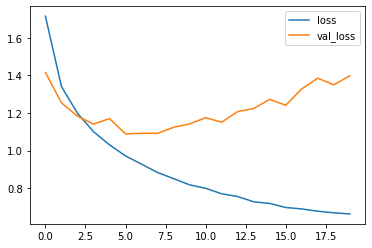

In [16]:
logs = pd.read_csv("save_model/log.tsv", sep="\t")
print(logs)
plt.plot(logs["loss"], label="loss")
plt.plot(logs["val_loss"], label="val_loss")
plt.legend()

In [17]:
model.predict()

In [37]:
dtest = iter(testloader)
X_test, y_test = dtest.next()
y_pred = model.predict(X_test)
print(y_test)
print(y_pred)

Prediction steps: 1 0.00s                          
tensor([3, 8, 8, 0])
[[-0.55828416 -0.2384777  -0.0848926   2.7825708   0.52510405  0.62369066
  -1.0325769  -0.5412121   1.1000988  -0.9982494 ]
 [ 5.1641016   5.311208   -2.4561455  -2.583716   -3.0548964  -3.4729667
  -3.2887967  -2.3266647   5.3098917   3.7565691 ]
 [ 4.015326    0.32558477  1.0491915  -1.335276   -0.7298944  -2.1109707
  -3.1632957  -1.6665176   1.443564    0.66177076]
 [ 5.4974394  -1.7213686   1.7904148  -2.3540545   1.0877429  -3.009136
  -2.449864   -3.730566    3.379003   -0.08497411]]


In [31]:
model.evaluate_generator(testloader)

Test steps: 2500 4.57s test_loss: 1.088866                                   


1.0888656394772231